# Flair Evaluation - 01 -

In diesem notebook wird untersucht wie gut Flair die gewünschten Entitäten (EVENT, TOPIC, DATE, TIME, LOC) erkennt.

Es wird folgendes Model genutzt: **"ner_german_large"**   
(large 4-class NER model for German),   
F1-Score: 92,31 (CoNLL-03 German revised)  
kann vier Entitäten erkennen:  
PER, LOC, ORG, MISC  

Es wird deshalb erwartet, das nur LOC im Datensatz erkannt wird.  


---
### 1. Test auf einem Text

In [1]:
from flair.data import Sentence
from flair.models import SequenceTagger

tagger = SequenceTagger.load("flair/ner-german-large")   
sentence = Sentence("SPRACHCAFE WEIHNACHTSFEIER DIENSTAG 21.12. OLOF-PALME ZENTRUM 19 UHR WIR FREUEN UNS AUF EUCH!")
tagger.predict(sentence)

print(sentence.to_tagged_string())

2025-07-27 13:03:21,363 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, B-PER, E-PER, S-LOC, B-MISC, I-MISC, E-MISC, S-PER, B-ORG, E-ORG, S-ORG, I-ORG, B-LOC, E-LOC, S-MISC, I-PER, I-LOC, <START>, <STOP>
Sentence[15]: "SPRACHCAFE WEIHNACHTSFEIER DIENSTAG 21.12. OLOF-PALME ZENTRUM 19 UHR WIR FREUEN UNS AUF EUCH!" → ["WEIHNACHTSFEIER"/MISC, "DIENSTAG"/LOC, "OLOF-PALME ZENTRUM"/LOC]


In [2]:
print(dir(sentence))

['_Sentence__remove_zero_width_characters', '_Sentence__restore_windows_1252_characters', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_token', '_embeddings', '_handle_problem_characters', '_has_context', '_known_spans', '_metadata', '_next_sentence', '_position_in_dataset', '_previous_sentence', '_printout_labels', '_start_position', 'add_label', 'add_metadata', 'annotation_layers', 'clear_embeddings', 'copy_context_from_sentence', 'embedding', 'end_position', 'get_each_embedding', 'get_embedding', 'get_label', 'get_labels', 'get_language_code', 'get_metadata', 'get_relations', 'get_span', 'get_spans', 'get_token', 'has_label', 'has_

---
### 2. Evaluation auf gesamten Datensatz 

Es wird nicht auf Token-Ebene (einzelne Wörter), sondern auf Span-Ebene untersucht, also auf zusammenhängende Entitäten mit ihrer jeweiligen Start und End Position im Text. Konkret: Start - Endpostion, Label und Text müssen bei NER und Goldstandard exakt gleich sein.  
Es werden nur die relevanten Labels EVENT, TOPIC, DATE, TIME und LOC betrachtet

In [1]:
# Importieren des annotierten Datensatzes
import json
with open("../../data/data_annotated.json", encoding="utf-8") as f:
    all_data = json.load(f)

In [2]:
# Funktion zur Extraktion der Entitäten aus dem Text durch Flair // "get_spans("ner")" gibt text, Start- und Endposition und Label aus
from flair.data import Sentence
from flair.models import SequenceTagger

tagger = SequenceTagger.load("flair/ner-german-large")  

def extract_flair_entities(text):
    sentence = Sentence(text)
    tagger.predict(sentence)
    predicted = []

    for entity in sentence.get_spans("ner"):
        predicted.append({
            "text": entity.text,
            "start": entity.start_position,
            "end": entity.end_position,
            "label": entity.get_label("ner").value
        })
    return predicted

2025-07-27 17:36:02,862 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, B-PER, E-PER, S-LOC, B-MISC, I-MISC, E-MISC, S-PER, B-ORG, E-ORG, S-ORG, I-ORG, B-LOC, E-LOC, S-MISC, I-PER, I-LOC, <START>, <STOP>


In [8]:
# Iteration auf dem gesamten Datensatz, Berechnung der Metriken, Speichern des NER Outputs im im Json
from collections import Counter, defaultdict
import json

# Funktion zur erstellung des dictionary
def span_to_dict(span, text):
    return {
        "text": text[span[0]:span[1]],
        "start": span[0],
        "end": span[1],
        "label": span[2]
    }


tp, fp, fn = 0, 0, 0
label_stats = defaultdict(lambda: [0, 0, 0])  # TP, FP, FN pro Label
relevant_labels = {"EVENT", "TOPIC", "TIME", "DATE", "LOC"}
all_results = []

for eintrag in all_data:
    file_name = eintrag.get("file_name", None)
    text = eintrag["text"]
    gold = eintrag.get("entities", [])
    predicted = extract_flair_entities(text)

    # Set aus (start, end, label)
    gold_spans = {(e["start"], e["end"], e["label"]) for e in gold if e["label"] in relevant_labels}
    pred_spans = {(e["start"], e["end"], e["label"]) for e in predicted if e["label"] in relevant_labels}

    # Gesamtmetriken
    tp += len(gold_spans & pred_spans)
    fp += len(pred_spans - gold_spans)
    fn += len(gold_spans - pred_spans)

    # für Berechnung pro Eintrag
    tp_spans = gold_spans & pred_spans
    fp_spans = pred_spans - gold_spans
    fn_spans = gold_spans - pred_spans
    
    tp_count = len(tp_spans)
    fp_count = len(fp_spans)
    fn_count = len(fn_spans)
    
    # lokale Metriken für dieses Dokument berechnen
    precision_local = tp_count / (tp_count + fp_count) if (tp_count + fp_count) > 0 else 0
    recall_local = tp_count / (tp_count + fn_count) if (tp_count + fn_count) > 0 else 0
    f1_local = 2 * precision_local * recall_local / (precision_local + recall_local) if (precision_local + recall_local) > 0 else 0
    

    # Pro Label
    for label in set([e["label"] for e in gold + predicted]):
        if label not in relevant_labels:
            continue 
    
        g = {s for s in gold_spans if s[2] == label}
        p = {s for s in pred_spans if s[2] == label}
        label_stats[label][0] += len(g & p)      # TP
        label_stats[label][1] += len(p - g)      # FP
        label_stats[label][2] += len(g - p)      # FN

    result = {
    "file_name": file_name,
    "text": text,
    "precision": precision_local,
    "recall": recall_local,
    "f1": f1_local,
    "true_positives": [span_to_dict(s, text) for s in tp_spans],
    "false_positives": [span_to_dict(s, text) for s in fp_spans],
    "false_negatives": [span_to_dict(s, text) for s in fn_spans],

    }


    all_results.append(result)

# Speichern der results / Ergebnis pro Eintrag
with open("../../data/NER/flair/results_ner_german_large.json", "w", encoding="utf-8") as f:
    json.dump(all_results, f, ensure_ascii=False, indent=2)


# -------------------------
# 5. Gesamtergebnisse
# -------------------------

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print("\n=== Gesamtbewertung ===")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1-Score : {f1:.2f}")

# -------------------------
# 6. Bewertung pro Label
# -------------------------

print("\n=== Bewertung pro Label ===")
for label, (tp_l, fp_l, fn_l) in label_stats.items():
    p = tp_l / (tp_l + fp_l) if (tp_l + fp_l) > 0 else 0
    r = tp_l / (tp_l + fn_l) if (tp_l + fn_l) > 0 else 0
    f = 2 * p * r / (p + r) if (p + r) > 0 else 0
    print(f"{label:<10} P: {p:.2f}  R: {r:.2f}  F1: {f:.2f}")


=== Gesamtbewertung ===
Precision: 0.41
Recall   : 0.13
F1-Score : 0.20

=== Bewertung pro Label ===
LOC        P: 0.41  R: 0.45  F1: 0.43
TIME       P: 0.00  R: 0.00  F1: 0.00
DATE       P: 0.00  R: 0.00  F1: 0.00
EVENT      P: 0.00  R: 0.00  F1: 0.00
TOPIC      P: 0.00  R: 0.00  F1: 0.00


---> wie erwartet wird außer LOC keine andere Entität erkannt  
---> wenn man nur die Werte von LOC betrachtet, immer noch weit entfernt vom propagierten F1-Score 92,31

**eine mögliche Ursachen für schlechten  Wert:** 
- unterschiedliche Start und End Positionen bei vorhergesagten und Goldstandard Entities


---
#### Untersuchung, ob unterschiedliche Start- und Endpositionen bei predicted und Goldstandard Ursache für schlechte Werte sind

In [5]:
from collections import defaultdict
import json

with open("../../data/NER/flair/results_ner_german_large.json", encoding="utf-8") as f:
    pred_data = json.load(f)

with open("../../data/data_annotated.json", encoding="utf-8") as f:
    gold_data = json.load(f)

def span_text(span, text):
    return text[span[0]:span[1]]

def fuzzy_match(gold_span, pred_span, tolerance=2):
    return (
        gold_span[2] == pred_span[2] and
        abs(gold_span[0] - pred_span[0]) <= tolerance and
        abs(gold_span[1] - pred_span[1]) <= tolerance
    )

# Index predicted nach file_name
pred_index = {entry["file_name"]: entry for entry in pred_data}


tp = 0
overlap_matches = 0  # nur text und label sind gleich
fuzzy_matches = 0    # text und label sind gleich und position weicht um maximal 2 Zeichen ab

for eintrag in gold_data:
    file_name = eintrag.get("file_name")
    text = eintrag["text"]
    gold = [e for e in eintrag.get("entities", []) if e["label"] == "LOC"]

    pred_entry = pred_index.get(file_name, {})
    # Kombiniere TP und FP, FN interessieren hier nicht
    predicted = pred_entry.get("true_positives", []) + pred_entry.get("false_positives", [])
    predicted = [e for e in predicted if e["label"] == "LOC"]

    # Erstelle Sets für TP-Zählung
    gold_spans = {(e["start"], e["end"], e["label"]) for e in gold}
    pred_spans = {(e["start"], e["end"], e["label"]) for e in predicted}

    tp += len(gold_spans & pred_spans)

    gold_spans_list = list(gold_spans)
    pred_spans_list = list(pred_spans)

    # Overlap: label und Text gleich
    matched_pred_indices = set()
    for g in gold_spans:
        for i, p in enumerate(pred_spans_list):
            if i in matched_pred_indices:
                continue
            if g[2] == p[2] and span_text(g, text) == span_text(p, text):
                overlap_matches += 1
                matched_pred_indices.add(i)
                break

    # Fuzzy Match: ±2 Zeichen Toleranz bei Start/Ende
    matched_pred_indices_fuzzy = set()
    for g in gold_spans_list:
        for i, p in enumerate(pred_spans_list):
            if i in matched_pred_indices_fuzzy:
                continue
            if fuzzy_match(g, p):
                fuzzy_matches += 1
                matched_pred_indices_fuzzy.add(i)
                break

print(f"\n=== LOC-Ergebnisse ===")
print(f"True Positives (genau): {tp}")
print(f"Overlap Matches (Text & Label gleich): {overlap_matches}")
print(f"Fuzzy Matches (±2 Zeichen): {fuzzy_matches}")
print(f"Fuzzy Matches ohne Overlaps: {fuzzy_matches - overlap_matches}")



=== LOC-Ergebnisse ===
True Positives (genau): 188
Overlap Matches (Text & Label gleich): 191
Fuzzy Matches (±2 Zeichen): 198
Fuzzy Matches ohne Overlaps: 7


Insgesamt wurden 198 LOC-Entitäten als fuzzy matches erkannt, d. h. mit korrekt erkanntem Label und maximal ±2 Zeichen Positionsabweichung. Davon waren 188 True Positives, also exakt richtig positioniert.  

Das bedeutet: 10 LOCs wurden inhaltlich korrekt erkannt, aber nicht exakt an der richtigen Position. Diese lagen entweder knapp daneben (innerhalb der Fuzzy-Toleranz) oder hatten nur den richtigen Text (Overlap), aber eine größere Positionsabweichung.  

Da sich Overlap- und Fuzzy-Matches überschneiden können, lässt sich nicht eindeutig sagen, ob die 3 zusätzlichen Overlap-Matches in den 10 fuzzy-only Fällen enthalten sind oder ganz andere Treffer mit falscher Position darstellen.


---> Da 10 erkannte Entitäten mit falscher Position eine relativ kleine Anzahl ist die schlechte Vorhersage von LOC nicht primär durch unterschiedlichen Positionen von Goldstandard und prediction begründet.

---> zum Vergleich: wie viele LOC Entitäten sind im gold standard vorhanden?

In [7]:
import json

with open("../../data/data_annotated.json", encoding="utf-8") as f:
    data = json.load(f)

count = 0
for item in data:
    for entity in item["entities"]:
        if entity["label"] == "LOC":
            count += 1

print(f"Anzahl LOC: {count}")

Anzahl LOC: 415


---
---
#### Metriken berechnen für alle Entitäten außer TOPIC (für Vergleich mit regelbasierter optimierter Variante)

In [6]:


from collections import defaultdict
import json

with open("../../data/NER/flair/results_ner_german_large.json", encoding="utf-8") as f:
    pred_data = json.load(f)

with open("../../data/data_annotated.json", encoding="utf-8") as f:
    gold_data = json.load(f)

# Index predicted nach file_name
pred_index = {entry["file_name"]: entry for entry in pred_data}

relevant_labels = {"EVENT", "TIME", "DATE", "LOC"}

# Initialisierung
tp, fp, fn = 0, 0, 0
label_stats = defaultdict(lambda: [0, 0, 0])  # TP, FP, FN pro Label

for eintrag in gold_data:
    file_name = eintrag.get("file_name")
    text = eintrag["text"]
    gold = [e for e in eintrag.get("entities", []) if e["label"] in relevant_labels]

    pred_entry = pred_index.get(file_name, {})
    predicted = pred_entry.get("true_positives", []) + pred_entry.get("false_positives", [])

    predicted = [e for e in predicted if e["label"] in relevant_labels]

    gold_spans = {(e["start"], e["end"], e["label"]) for e in gold}
    pred_spans = {(e["start"], e["end"], e["label"]) for e in predicted}

    tp_set = gold_spans & pred_spans
    fp_set = pred_spans - gold_spans
    fn_set = gold_spans - pred_spans

    tp += len(tp_set)
    fp += len(fp_set)
    fn += len(fn_set)

    for label in relevant_labels:
        g = {s for s in gold_spans if s[2] == label}
        p = {s for s in pred_spans if s[2] == label}
        label_stats[label][0] += len(g & p)
        label_stats[label][1] += len(p - g)
        label_stats[label][2] += len(g - p)

# -------------------------
# 5. Gesamtergebnisse
# -------------------------

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print("\n=== Gesamtbewertung (nur relevante Labels) ===")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1-Score : {f1:.2f}")

# -------------------------
# 6. Bewertung pro Label
# -------------------------

print("\n=== Bewertung pro Label ===")
for label, (tp_l, fp_l, fn_l) in label_stats.items():
    p = tp_l / (tp_l + fp_l) if (tp_l + fp_l) > 0 else 0
    r = tp_l / (tp_l + fn_l) if (tp_l + fn_l) > 0 else 0
    f = 2 * p * r / (p + r) if (p + r) > 0 else 0
    print(f"{label:<10} P: {p:.2f}  R: {r:.2f}  F1: {f:.2f}")



=== Gesamtbewertung (nur relevante Labels) ===
Precision: 0.41
Recall   : 0.16
F1-Score : 0.23

=== Bewertung pro Label ===
DATE       P: 0.00  R: 0.00  F1: 0.00
LOC        P: 0.41  R: 0.45  F1: 0.43
TIME       P: 0.00  R: 0.00  F1: 0.00
EVENT      P: 0.00  R: 0.00  F1: 0.00


---
### Diagramme

In [1]:
# JSON in CSV wandeln und speichern
import json
import pandas as pd

# JSON-Datei laden
with open("../../data/NER/flair/results_ner_german_large.json", "r") as f:
    data = json.load(f)  

# Nur gewünschte Felder extrahieren
filtered_data = [
    {
        "file_name": entry["file_name"],
        "precision": entry["precision"],
        "recall": entry["recall"],
        "f1": entry["f1"]
    }
    for entry in data
]

# In DataFrame und CSV schreiben
df = pd.DataFrame(filtered_data)
df.to_csv("../../data/NER/flair/results_ner_german_large.csv", index=False)


In [3]:
import pandas as pd

df = pd.read_csv("../../data/NER/flair/results_ner_german_large.csv")
df.head(2)

,file_name,precision,recall,f1
0,0001.jpg,0.500000,0.166667,0.250000
1,0002.jpg,0.666667,0.333333,0.444444


In [5]:
# mit category joinen
df_pics = pd.read_csv("../../data/image_data_with_groundtruth.csv")
# Nur die Spalten "name" und "category" 
df_pics_little = df_pics[["file_name", "category"]]

# Merge 
merged_df = df.merge(df_pics_little, on="file_name", how="left")


merged_df.head(2)

,file_name,precision,recall,f1,category
0,0001.jpg,0.500000,0.166667,0.250000,noisy
1,0002.jpg,0.666667,0.333333,0.444444,noisy


In [6]:
merged_df.to_csv("../../data/NER/flair/results_ner_german_large_with_category.csv", index=False)

In [7]:
df = pd.read_csv("../../data/NER/flair/results_ner_german_large_with_category.csv")

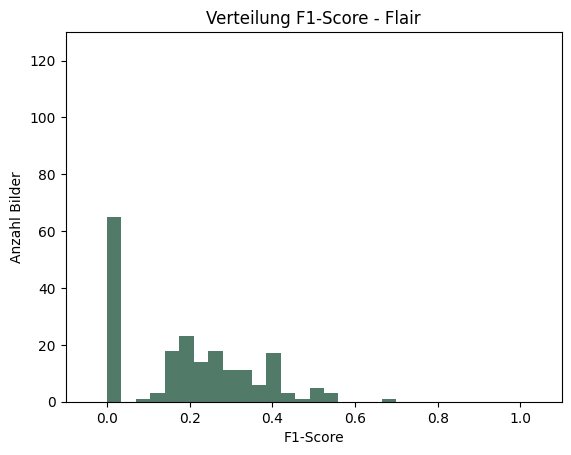

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("../../data/NER/flair/results_ner_german_large_with_category.csv") 
wer_values = df["f1"] 

plt.hist(wer_values, bins=20, color='#527a68')
plt.ylim(0, 130)
plt.xlim(-0.1, 1.1)
plt.xlabel('F1-Score')
plt.ylabel('Anzahl Bilder')
plt.title('Verteilung F1-Score - Flair')
plt.grid(False)
plt.show()


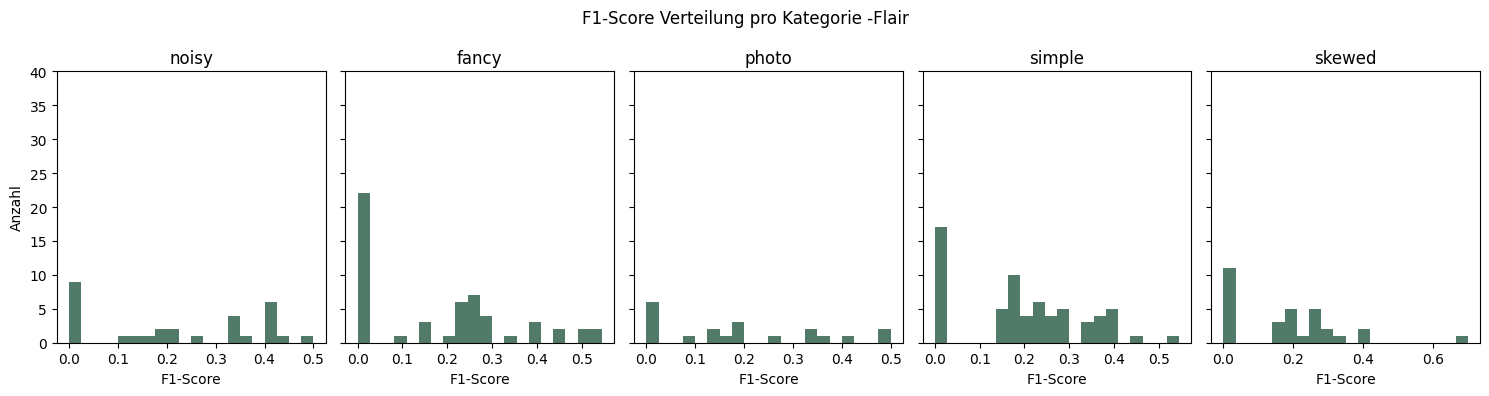

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

categories = df['category'].unique()

fig, axs = plt.subplots(1, len(categories), figsize=(15, 4), sharey=True)

for i, cat in enumerate(categories):
    subset = df[df['category'] == cat]
    axs[i].hist(subset['f1'], bins=20, color='#527a68')
    axs[i].set_title(cat)
    axs[i].set_xlabel('F1-Score')

axs[0].set_ylabel('Anzahl')
plt.ylim(0, 40)
plt.suptitle('F1-Score Verteilung pro Kategorie -Flair')
plt.tight_layout()
plt.show()

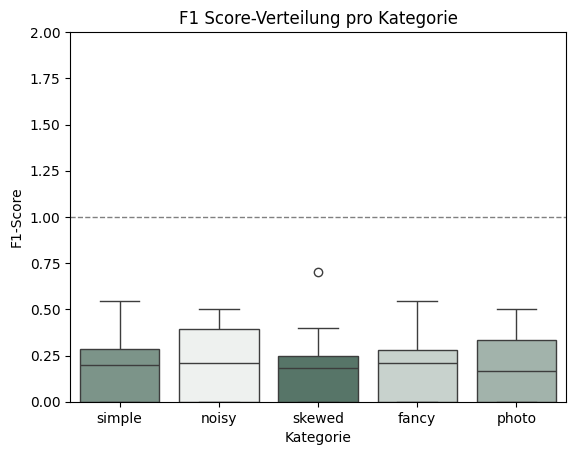

In [22]:
import pandas as pd
import seaborn as sns


categories = ['simple', 'noisy', 'skewed', 'fancy', 'photo']


sns.boxplot(data=df, x='category', y='f1',  hue='category', palette='light:#527a68', order=categories)
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.title('F1 Score-Verteilung pro Kategorie')
plt.xlabel('Kategorie')
plt.ylabel('F1-Score')
plt.ylim(0, 2)
plt.grid(False)
plt.show()

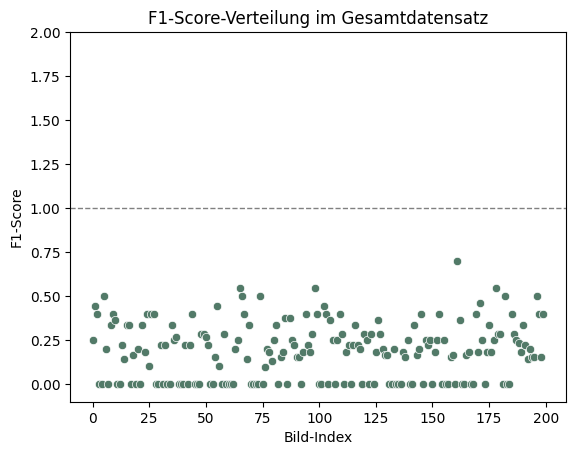

In [24]:
sns.scatterplot(x=range(len(df)), y=df['f1'], color='#527a68')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.title('F1-Score-Verteilung im Gesamtdatensatz')
plt.xlabel('Bild-Index')
plt.ylabel('F1-Score')
plt.ylim(-0.1, 2)
plt.grid(False)
plt.show()